## Primer ejemplo de Red Neuronal para el Master de Data Science de Nuclio School


Recordemos los pasos a seguiren la creación de código para entrenar una red neuronal:
<ol>
    <li>Importar librerias: Keras, PyPlot y Numpy (añado time y datetime para controlar los tiempos de entrenamiento)</li>
    <li>Definamos una red inicial (apilando bloques)</li>
    <li>Definimos (o creamos) nuestro optimizador, añadiendo nuestra función error</li>
    <li>Preparamos los datos (en este caso los cargamos)</li>
    <li>Empezamos con el entrenamiento</li>
    <li>Miramos los resultados y pasamos a la crítica mordaz</li>
</ol>

## 1. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [4]:
from tensorflow import keras as ks
from matplotlib import pyplot as plt
import numpy as np
import time
import datetime

La entrada del modelo como podeis ver son imagenes, hasta ahí todo claro, como es cada una de estas imagenes? Pues cada una de estas imagenes tienen 28px de alto por 28px de ancho. Vamos a ver una de estas imagenes

In [5]:
mnist = ks.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
imagen_muestra = x_train[0]
imagen_muestra.shape

11490434/11490434 [==============================] - 1s 0us/step


(28, 28)

## 2. Arquitectura de red del modelo

Construimos un modelo sencillo de red neuronal para los datos MNIST, que en resumen son:
- Datos de entrada: imagenes de 28x28 pixeles con un canal de grises (valores de 1 a 256, enteros)
- Datos de salida (labels): a cada imagen le otorgamos un valor de 0 a 9, un total de 10 classes

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/05/Examples-from-the-MNIST-dataset.png">

Para montar la arquitectura de la red neuronal se sigue el método **.Sequential()** de Keras (de input a output):

- **Entrada** - Una conversion de una matriz 2D de 28x28 pixeles a un vector - método Flatten
- **Oculto** - Una capa densa (fully connected) con 16 neuronas y activación lineal
- **Salida** - Una capa densa (fully connected) con 10 neuronas (**las 10 clases de salida**) y activación lineal

<img alt="" src="//upload.wikimedia.org/wikipedia/commons/thumb/1/11/Colored_neural_network_es.svg/300px-Colored_neural_network_es.svg.png" decoding="async" width="300" height="361" class="thumbimage" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/1/11/Colored_neural_network_es.svg/450px-Colored_neural_network_es.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/1/11/Colored_neural_network_es.svg/600px-Colored_neural_network_es.svg.png 2x" data-file-width="296" data-file-height="356">

Cada uno de estos pixeles está representado en python como un valor de 0 a 255, de hecho si vemos la primera y la 14ava fila de pixeles, por ejemplo veremos a que nos referimos

In [6]:
print(imagen_muestra[0])
print(imagen_muestra[13])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0   0   0   0   0  35 241 225 160 108   1
   0   0   0   0   0   0   0   0   0   0]


Como estas imagenes están en escala de grises cada valor representa un tono de gris, desde el 0 que es el negro hasta el 255 que es el blanco, pasando por todos los tonos intermedios

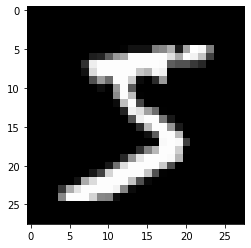

In [7]:
plt.imshow(imagen_muestra, cmap='gray')

Para que veais que aqui no hay trampa ni cartón podemos modificar la imagen de muestra y pintarla de nuevo

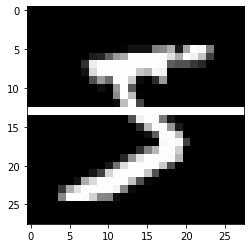

In [8]:
imagen_muestra[13] = 28*[255]
plt.imshow(imagen_muestra, cmap='gray')

In [9]:
#####
import tensorflow as tf
image = [
         [0, 31, 63],
         [95, 127, 159],
         [91, 223, 255]]

image = tf.convert_to_tensor(image)
# [3, 3] ------> [9]
image_batch = tf.expand_dims(image, [0])

model_flatten = ks.Sequential([
  ks.layers.Flatten(input_shape=(3, 3))
])

output = model_flatten.predict(image_batch)
print(output.shape)
output

1/1 [==============================] - 0s 112ms/step
(1, 9)


array([[  0.,  31.,  63.,  95., 127., 159.,  91., 223., 255.]],
      dtype=float32)

In [10]:
model = ks.Sequential()

model.add(ks.layers.Flatten(input_shape=(28, 28)))
model.add(ks.layers.Dense(32, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(16, activation='relu'))
model.add(ks.layers.Dense(10, activation='softmax'))

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense (Dense)               (None, 32)                25120     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 10)                170       
                                                                 
Total params: 25818 (100.85 KB)
Trainable params: 25818 (100.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Para revisar un modelo, nos basta con llamar al método **.summary()** del modelo

tDel **.summary()** se extrae información muy relevante: el número de paràmetros por capa y el total a entrenar.4

Fijaos que 28x28 son 784 valores, así que es lo que tenemos de entrada. Esos 784 neuronas se enlazan con 16 (16 * 784 pesos + 16 bias = 12560) y esas 16 con las 10 de salida (16 * 10 pesos + 10 bias). Un total de 12730 parametros que aprender  

## 3. Optimizador, función error

Definimos los parametros del modelo para su entrenamiento:
* **Loss** - Función de error (función de coste) - Optamos por la Sparse Categorical Crosstentropy porque estamos clasificando imagenes
* **Optimizer** - que optimizador de la función de coste usaremos, en este ejemplo SGD (Stochastic gradient descent)
* **Metrics** - que metrica usaremos para evaluar el modelo... en este caso se usa la Accuracy

**Nota sobre SGD:** por defecto lleva un learning rate de 0.01 y sin momentum (valor de 0.0)

In [12]:
model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'], )

## 4. Preparamos los datos

Cargamos los datos de MNIST de los datasets directamente de las librerias de Keras. Estos ya estan dispuestos en train and test

**Detalle importante:**
> La red neuronal requiere que los inputs sean números reales, y lo haremos forzando la division de los valores de dentro de las matrices 28x28 (que tienen valoress del 0 al 255) por 255.0 (un real)

In [13]:
mnist = ks.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape
x_test.shape

(10000, 28, 28)

In [14]:
mnist = ks.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Dividimos los valores en 255.0 para convertir los valores de los pixeles de
# 0 a 255 a valores entre 0 y 1, un 1 será un blaco y un 0 un negro
x_train, x_test = x_train / 255.0, x_test / 255.0

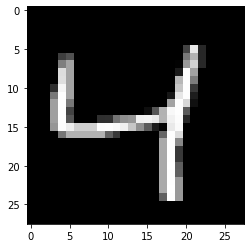

In [15]:
(xv_train, yv_train), (xv_test, yv_test) = mnist.load_data()
plt.imshow(xv_train[2], cmap='gray')

Pintemos una muestra de las imagenes del dataset MNIST, a ver si se parece en algo a lo que esperamos.
Primero, vemos que tipos de datos tengo, después mapeamos esas matrices en una escala de grises utilizando el método **.get_cmap()** de PlotLy con los nueve primeros números del dataset.

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


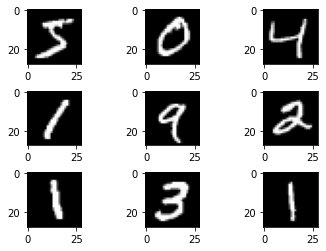

In [16]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))

for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))

plt.subplots_adjust(hspace = 0.5)
plt.show()

Como vamos a querer ir haciendo validación a la vez que entrenamos (muy practico)

In [17]:
x_val = x_train[-10000:]
y_val = y_train[-10000:]

x_train = x_train[:-10000]
y_train = y_train[:-10000]

In [18]:
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
print('Valid: X=%s, y=%s' % (x_val.shape, y_val.shape))

Train: X=(50000, 28, 28), y=(50000,)
Test: X=(10000, 28, 28), y=(10000,)
Valid: X=(10000, 28, 28), y=(10000,)


In [19]:
# Veamos las etiquetas
y_train

array([5, 0, 4, ..., 8, 4, 8], dtype=uint8)

## 5. Entrenamiento

Ya podemos ponernos a entrenar el modelo!!

Empezaremos con 30 epocs, es decir, 30 pasadas completas del dataset (que a su vez sera con mini-batches internamente), por defecto en Keras, **el batch_size es de 32**.

El metodo .fit() nos permite, definir además si disponemos de varias CPUs, GPUs, y si queremos ir validando datos a cada fin de epoch.

**Nota: Este fit, en mi laptop no tarda más de 2 minutos.** (por eso vale la pena capturar los tiempos, así podeis validar las capacidades de vuestro equipo y valorar Google Colab).

In [20]:
t = time.perf_counter()

In [21]:
history = model.fit(x_train, y_train, epochs=30, use_multiprocessing=False, validation_data=(x_val, y_val))

Epoch 1/30


1563/1563 [==============================] - 5s 2ms/step - loss: 0.6191 - accuracy: 0.8089 - val_loss: 0.2311 - val_accuracy: 0.9352
Epoch 2/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.3603 - accuracy: 0.8896 - val_loss: 0.1935 - val_accuracy: 0.9447
Epoch 3/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.3201 - accuracy: 0.9018 - val_loss: 0.1751 - val_accuracy: 0.9498
Epoch 4/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2949 - accuracy: 0.9102 - val_loss: 0.1641 - val_accuracy: 0.9529
Epoch 5/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2737 - accuracy: 0.9163 - val_loss: 0.1634 - val_accuracy: 0.9543
Epoch 6/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2644 - accuracy: 0.9184 - val_loss: 0.1532 - val_accuracy: 0.9567
Epoch 7/30
1563/1563 [==============================] - 4s 2ms/step - loss: 0.2525 - accuracy: 0.9210 - val_loss: 0.1523 - val_accuracy: 0.9562
Epo

In [22]:
elapsed_time = datetime.timedelta(seconds=(time.perf_counter() - t))

print('Tiempo de entrenamiento:', elapsed_time)

Tiempo de entrenamiento: 0:01:49.992863


## 6. Evaluamos los resultados

Obtengamos una grafica de como el error y la accuracy van evolucionando en cada epoch en los datos de entrenamiento y en la validación

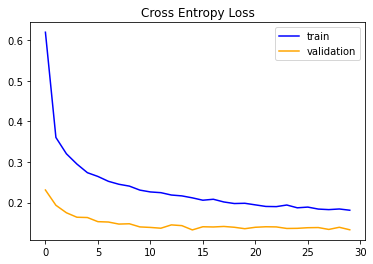

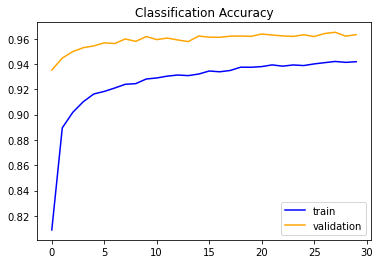

In [23]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

Evaluemos el modelo contra los valores de testeo

In [24]:
model.evaluate(x_test,  y_test, verbose=2)

313/313 - 0s - loss: 0.1397 - accuracy: 0.9602 - 415ms/epoch - 1ms/step


[0.1396716684103012, 0.9602000117301941]

El coste podemos ver que es estable. Además la accuracy baila muchísimo. No se puede decir que sea un modelo muy bueno.

Veamos que tipo de predicciones estoy obteniendo sobre el conjunto de test (vamos a pintar las imagenes y sus clasificaciones)

In [25]:
predictions = model.predict(x_test)

313/313 [==============================] - 0s 1ms/step


Una de las ventajas de Python es que hay montones de funciones y código realizado por terceras personas. Aquí me he fusilado unas bonitas funciones (que he adaptado un poco a mis necesidades) para poder pintar las imagenes, su label (ground truth) y las clasificaciones que hemos realizado.

In [26]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Dibujamos los primeros digitos, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo

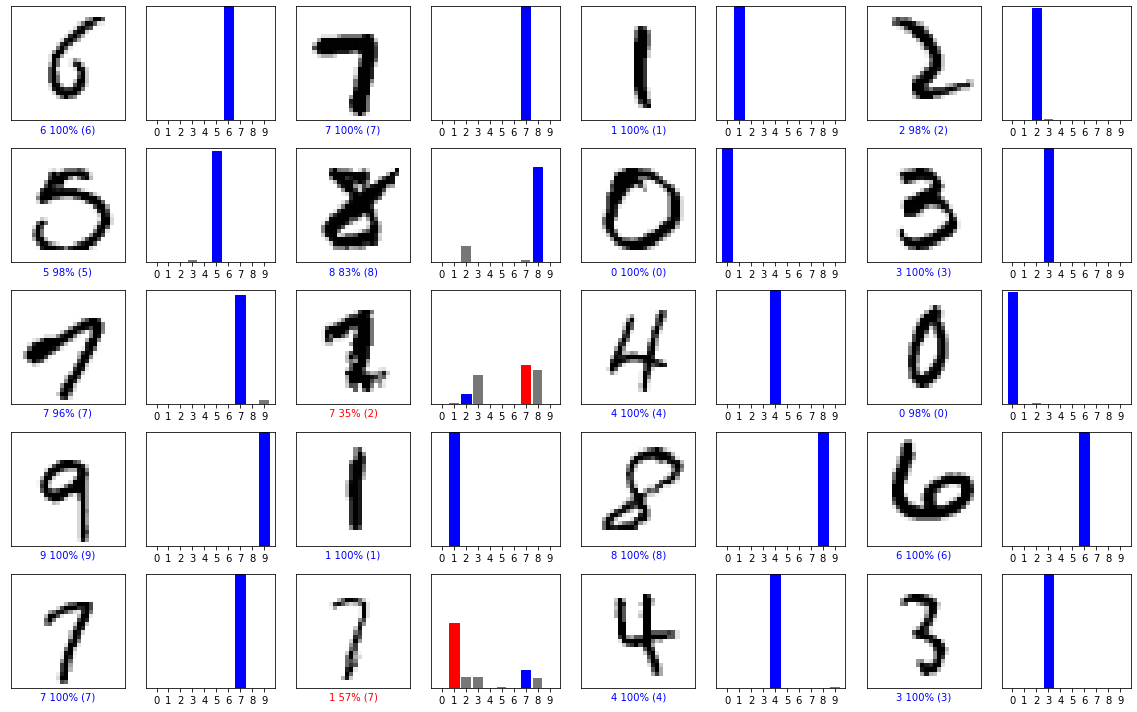

In [27]:
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test, x_test)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test)
plt.tight_layout()
plt.show()

In [28]:
from tensorflow.keras.models import load_model

model.save('mnist_model.h5')

c:\Users\alici\anaconda3\envs\Nuclio_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
